In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Data Preparation

In [129]:
data = pd.read_excel('./ts_project/Project1-2024.xlsx')
data['Date'] = pd.to_datetime(data['Date'])

In [130]:
data.head()

,Date,Income,Outcome,Balance
0,2017-01-09,1.343028,1.487865,-0.155904
1,2017-01-10,1.068610,1.194182,-0.125572
2,2017-01-11,0.944429,0.936663,0.007767
3,2017-01-12,1.672202,0.875379,0.800391
4,2017-01-13,0.955924,0.975645,-0.019721


In [131]:
data.shape

(1543, 4)

Подгрузим данные по ключевой ставке и инфляции с сайта ЦБ (https://www.cbr.ru/hd_base/infl/)

Здесь и далее будем шифтить значения на 1 назад, чтобы избежать ликов данных

In [132]:
CB = pd.read_excel('./ts_project/inf_key.xlsx') 
CB['Дата'] = pd.to_datetime(CB['Дата'])
CB.columns = ['Date', 'Key', 'Inflation']
CB = CB.sort_values('Date')
CB['Inflation'] = CB['Inflation'].shift(1)
CB['Key'] = CB['Key'].shift(1)
CB.head()

,Date,Key,Inflation
0,2016-01-01,NaN,NaN
1,2016-02-01,11.0,9.8
2,2016-03-01,11.0,8.1
3,2016-04-01,11.0,7.3
4,2016-05-01,11.0,7.3


Добавим лаги для добавленных фич

In [133]:
for i in [1,2,3,4,5,6]:
    CB[f'Key_lag{i}'] = np.NaN * CB.shape[0]
    for j in range(i, CB.shape[0]):
        
        CB.loc[j, f'Key_lag{i}'] = CB.loc[j-i,'Key']


for i in [1,2,3,4,5,6]:
    CB[f'Inflation_lag{i}'] = np.NaN * CB.shape[0]
    for j in range(i, CB.shape[0]):
        
        CB.loc[j, f'Inflation_lag{i}'] = CB.loc[j-i,'Inflation'] 

Добавим скользящие значения

In [134]:
rolling = CB[['Key', 'Inflation']].rolling(3).agg(['mean', 'std', 'median', 'max', 'min'])

rolling.dropna().head()

Key                              Inflation                           
        mean       std median   max   min      mean       std median  max  min
3  11.000000  0.000000   11.0  11.0  11.0  8.400000  1.276715    8.1  9.8  7.3
4  11.000000  0.000000   11.0  11.0  11.0  7.566667  0.461880    7.3  8.1  7.3
5  11.000000  0.000000   11.0  11.0  11.0  7.300000  0.000000    7.3  7.3  7.3
6  10.833333  0.288675   11.0  11.0  10.5  7.366667  0.115470    7.3  7.5  7.3
7  10.666667  0.288675   10.5  11.0  10.5  7.333333  0.152753    7.3  7.5  7.2

In [135]:
new_columns = [f'{col}_{stat}' for col in rolling.columns.levels[0] for stat in rolling.columns.levels[1]]
rolling.columns = new_columns
CB=pd.concat([CB,rolling],axis=1)
CB.head()

,Date,Key,Inflation,Key_lag1,Key_lag2,Key_lag3,Key_lag4,Key_lag5,Key_lag6,Inflation_lag1,...,Key_mean,Key_std,Key_median,Key_max,Key_min,Inflation_mean,Inflation_std,Inflation_median,Inflation_max,Inflation_min
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-01,11.0,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-03-01,11.0,8.1,11.0,NaN,NaN,NaN,NaN,NaN,9.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-04-01,11.0,7.3,11.0,11.0,NaN,NaN,NaN,NaN,8.1,...,11.0,0.0,11.0,11.0,11.0,8.400000,1.276715,8.1,9.8,7.3
4,2016-05-01,11.0,7.3,11.0,11.0,11.0,NaN,NaN,NaN,7.3,...,11.0,0.0,11.0,11.0,11.0,7.566667,0.461880,7.3,8.1,7.3


Подгрузим данные по курсу стоимости золота ЦБ (https://investfunds.ru/indexes/224/)

In [136]:
gold_price_cb = pd.read_excel('./ts_project/gold.xlsx')  
gold_price_cb['Date'] = pd.to_datetime(gold_price_cb['Date'])
gold_price_cb = gold_price_cb.sort_values('Date').reset_index(drop=True)
gold_price_cb['Gold'] = gold_price_cb['Gold'].shift(1)
gold_price_cb.head()

,Date,Gold
0,2016-01-01,NaN
1,2016-01-12,2490.71
2,2016-01-13,2697.53
3,2016-01-14,2696.48
4,2016-01-15,2658.20


Добавим лаги для добавленных фич

In [137]:
for i in [1,2,3,4,5,7,14,21,30]:
    gold_price_cb[f'Gold_lag{i}'] = np.NaN * gold_price_cb.shape[0]
    for j in range(i, gold_price_cb.shape[0]):
        
        gold_price_cb.loc[j, f'Gold_lag{i}'] = gold_price_cb.loc[j-i,'Gold']

Добавим скользящие значения

In [138]:
rolling_gold = gold_price_cb[['Gold']].rolling(7).agg(['mean', 'std', 'median', 'max', 'min'])

rolling_gold.dropna().head()
new_columns = [f'{col}_{stat}' for col in rolling_gold.columns.levels[0] for stat in rolling_gold.columns.levels[1]]
rolling_gold.columns = new_columns
gold_price_cb=pd.concat([gold_price_cb,rolling_gold],axis=1)
gold_price_cb.head()

,Date,Gold,Gold_lag1,Gold_lag2,Gold_lag3,Gold_lag4,Gold_lag5,Gold_lag7,Gold_lag14,Gold_lag21,Gold_lag30,Gold_mean,Gold_std,Gold_median,Gold_max,Gold_min
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-12,2490.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-13,2697.53,2490.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-14,2696.48,2697.53,2490.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-15,2658.20,2696.48,2697.53,2490.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подгрузим данные по курсу доллара и поплачем над былыми временами

In [139]:
usd_course = pd.read_csv('./ts_project/usd_rub_course.csv', parse_dates=['Date'], index_col='Date')        
usd_course = usd_course.resample('1D').sum()['Close'].shift(1).dropna().to_frame()
usd_course.columns = ['usd_rub_course']
usd_course = usd_course.reset_index(drop=False)
usd_course['Date'] = pd.to_datetime(usd_course['Date'])
usd_course['usd_rub_course'][usd_course['usd_rub_course'] == 0] = np.nan

for i in [1,2,3,4,5,7,14,21,30]:
    usd_course[f'usd_rub_course_lag{i}'] = np.NaN * usd_course.shape[0]
    for j in range(i, usd_course.shape[0]):
        usd_course.loc[j, f'usd_rub_course_lag{i}'] = usd_course.loc[j-i,'usd_rub_course']

usd_course.head()

,Date,usd_rub_course,usd_rub_course_lag1,usd_rub_course_lag2,usd_rub_course_lag3,usd_rub_course_lag4,usd_rub_course_lag5,usd_rub_course_lag7,usd_rub_course_lag14,usd_rub_course_lag21,usd_rub_course_lag30
0,2003-12-02,29.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-12-03,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-12-04,29.690001,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-12-05,29.680000,29.690001,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-12-06,29.620001,29.680000,29.690001,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN


In [140]:
rolling_usd = usd_course[['usd_rub_course']].rolling(5).agg(['mean', 'std', 'median', 'max', 'min'])
rolling_usd.dropna().head()

usd_rub_course                                           
             mean       std     median        max        min
4       29.676001  0.032094  29.690001  29.700001  29.620001
11      29.468000  0.081364  29.510000  29.540001  29.370001
18      29.280000  0.057879  29.250000  29.379999  29.240000
25      29.252000  0.027748  29.240000  29.299999  29.230000
39      29.152000  0.133304  29.230000  29.250000  28.940001

In [141]:
new_columns = [f'{col}_{stat}' for col in rolling_usd.columns.levels[0] for stat in rolling_usd.columns.levels[1]]
rolling_usd.columns = new_columns
usd_course = pd.concat([usd_course,rolling_usd],axis=1)
usd_course.head()

,Date,usd_rub_course,usd_rub_course_lag1,usd_rub_course_lag2,usd_rub_course_lag3,usd_rub_course_lag4,usd_rub_course_lag5,usd_rub_course_lag7,usd_rub_course_lag14,usd_rub_course_lag21,usd_rub_course_lag30,usd_rub_course_mean,usd_rub_course_std,usd_rub_course_median,usd_rub_course_max,usd_rub_course_min
0,2003-12-02,29.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-12-03,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-12-04,29.690001,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-12-05,29.680000,29.690001,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-12-06,29.620001,29.680000,29.690001,29.690001,29.700001,NaN,NaN,NaN,NaN,NaN,29.676001,0.032094,29.690001,29.700001,29.620001


Подгрузим данные по ВВП из Росстата

In [142]:
GDP = pd.read_excel('./ts_project/macroeconomics.xlsx') 
GDP.head(5)

,date_start,date_end,GDP_curr_price,GDP_2016_price,GDP_2016_price_without_season,GDP_2021_price,GDP_2021_price_without_season,YoY_physical_volume_GDP,YoY_deflator_GDP
0,2017-01-01,2017-03-31,20586.119060,19615.838621,21637.001573,28157.688114,31125.040997,101.309933,107.597623
1,2017-04-01,2017-06-30,21917.573773,21038.528127,21755.371308,30546.214436,31290.465665,102.341376,104.712965
2,2017-07-01,2017-09-30,23718.216151,22560.998081,21933.993888,32453.733645,31550.801090,102.637872,103.928582
3,2017-10-01,2017-12-31,25621.245234,23963.905417,21939.043771,34235.608726,31556.586792,101.040255,105.464446
4,2018-01-01,2018-03-31,22474.464293,20118.490163,22221.722923,28879.422818,31964.271403,102.563189,106.444531


Объединим все датасеты в один

In [143]:
data.index = data['Date']
CB.index = CB['Date']
gold_price_cb.index = gold_price_cb['Date']

In [144]:
#добавим инфляцию и ключ
data = pd.merge_asof(left=data,right=CB,right_index=True,left_index=True,direction='backward')
data = data.drop(columns = ['Date_y']) 
data = data.rename(columns = {'Date_x': 'Date'})

#добавим золото
data = pd.merge_asof(left=data, right=gold_price_cb,right_index=True,left_index=True,direction='backward')
data = data.drop(columns = ['Date_y']) 
data = data.rename(columns = {'Date_x': 'Date'})

#добавим изменение статистик инфляции и ключа
data['Inflation_diff'] = data['Inflation'] - data['Inflation'].shift()
data['Key_diff'] = data['Key'] - data['Key'].shift() 
data = data.fillna(0) 
data = data.reset_index(drop=True)

#добавим курс доллара
data = pd.merge(data, usd_course, left_on='Date', right_on='Date', how='left').fillna(method='ffill')

#добавим показатели ВВП
columns_to_add = ['GDP_curr_price', 'GDP_2016_price',
                  'GDP_2016_price_without_season', 'GDP_2021_price',
                  'GDP_2021_price_without_season', 'YoY_physical_volume_GDP',
                  'YoY_deflator_GDP']

for column in columns_to_add:
    data[column] = np.nan

j = 0
for i in tqdm(range(GDP.shape[0]), desc='Processing...'):
    try:
        while data['Date'].loc[j] <= GDP['date_end'].loc[i]:
            data['GDP_curr_price'].loc[j] = GDP['GDP_curr_price'].loc[i]
            data['GDP_2016_price'].loc[j] = GDP['GDP_2016_price'].loc[i]
            data['GDP_2016_price_without_season'].loc[j] = GDP['GDP_2016_price_without_season'].loc[i]
            data['GDP_2021_price'].loc[j] = GDP['GDP_2021_price'].loc[i]
            data['GDP_2021_price_without_season'].loc[j] = GDP['GDP_2021_price_without_season'].loc[i]
            data['YoY_physical_volume_GDP'].loc[j] = GDP['YoY_physical_volume_GDP'].loc[i]
            data['YoY_deflator_GDP'].loc[j] = GDP['YoY_deflator_GDP'].loc[i]
            j += 1
    except KeyError:
        pass

data.head(5)

Processing...: 100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


,Date,Income,Outcome,Balance,Key,Inflation,Key_lag1,Key_lag2,Key_lag3,Key_lag4,...,usd_rub_course_median,usd_rub_course_max,usd_rub_course_min,GDP_curr_price,GDP_2016_price,GDP_2016_price_without_season,GDP_2021_price,GDP_2021_price_without_season,YoY_physical_volume_GDP,YoY_deflator_GDP
0,2017-01-09,1.343028,1.487865,-0.155904,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,20586.11906,19615.838621,21637.001573,28157.688114,31125.040997,101.309933,107.597623
1,2017-01-10,1.068610,1.194182,-0.125572,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,20586.11906,19615.838621,21637.001573,28157.688114,31125.040997,101.309933,107.597623
2,2017-01-11,0.944429,0.936663,0.007767,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,20586.11906,19615.838621,21637.001573,28157.688114,31125.040997,101.309933,107.597623
3,2017-01-12,1.672202,0.875379,0.800391,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,20586.11906,19615.838621,21637.001573,28157.688114,31125.040997,101.309933,107.597623
4,2017-01-13,0.955924,0.975645,-0.019721,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,20586.11906,19615.838621,21637.001573,28157.688114,31125.040997,101.309933,107.597623


Создадим также скользящие значения для таргета, добавим лаги. Не забудем про шифт дабы не допустить ликов!

In [145]:
data['MA7'] = data['Balance'].rolling(7).mean()
data['MA30'] = data['Balance'].rolling(30).mean()
rolling_target = data[['Balance']].rolling(7).agg(['mean', 'std', 'median', 'max', 'min']).shift(1)
new_columns = [f'{col}_{stat}' for col in rolling_target.columns.levels[0] for stat in rolling_target.columns.levels[1]]
rolling_target.columns = new_columns
data=pd.concat([data,rolling_target],axis=1)

for i in [1,2,3,4,5,7,14,21,30]:
    data[f'Target_lag{i}'] = np.NaN * data.shape[0]
    for j in range(i, data.shape[0]):
        
        data.loc[j, f'Target_lag{i}'] = data.loc[j-i, 'Balance']

### Добавление налоговых дат

In [146]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data.head()

,Date,Income,Outcome,Balance,Key,Inflation,Key_lag1,Key_lag2,Key_lag3,Key_lag4,...,Target_lag3,Target_lag4,Target_lag5,Target_lag7,Target_lag14,Target_lag21,Target_lag30,year,month,day
0,2017-01-09,1.343028,1.487865,-0.155904,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1,9
1,2017-01-10,1.068610,1.194182,-0.125572,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1,10
2,2017-01-11,0.944429,0.936663,0.007767,10.0,5.4,10.0,10.0,10.0,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1,11
3,2017-01-12,1.672202,0.875379,0.800391,10.0,5.4,10.0,10.0,10.0,10.5,...,-0.155904,NaN,NaN,NaN,NaN,NaN,NaN,2017,1,12
4,2017-01-13,0.955924,0.975645,-0.019721,10.0,5.4,10.0,10.0,10.0,10.5,...,-0.125572,-0.155904,NaN,NaN,NaN,NaN,NaN,2017,1,13


In [147]:
data['tax_day'] = ((data.day == 1) & (data.month.isin([12]))).astype(int)
data['all_tax'] = ((data.day == 28) & (data.month.isin([1,2,3,4,5,6,7,8,9,10,11,12]))).astype(int)
data['profit_tax'] = ((data.day == 20) & (data.month.isin([1,2,3,4]))).astype(int)
data['nds_tax'] = ((data.day == 20) & (data.month.isin([4, 7, 10, 1]))).astype(int)
data['essb_tax'] = ((data.day == 30) & (data.month.isin([4]))).astype(int)

## Добавление праздников

In [148]:
start_date = '2017-01-09'
end_date = '2021-03-31'

In [149]:
def process_holidays_data(data_path='./ts_project/calendar.csv', output_path='./ts_project/holidays_df.csv'):
    open_data_calendar = pd.read_csv(data_path)
    holiday_list = []
    for idx, row in open_data_calendar.iterrows():
        year = int(row['Год/Месяц'])
        for month_num, month in enumerate(open_data_calendar.columns[1:13]):
            month_val = month_num + 1
            for day_str in row[month].split(','):
                is_holiday = True if day_str[-1] != '*' else False
                if not is_holiday:
                    day = int(day_str.replace('*', '').replace('+', ''))
                    holiday_list.append(pd.Timestamp(year=year, month=month_val, day=day))
    
    holiday_df = pd.DataFrame(holiday_list, columns=['holidays'])
    holiday_df.set_index('holidays', inplace=True)
    holiday_df.sort_index(inplace=True)
    holiday_df.to_csv(output_path, index=False)
    return holiday_df

In [150]:
class RussianBusinessCalendar(AbstractHolidayCalendar):
    def __init__(self, holiday_df):
        self.start_date = datetime.datetime(2017, 1, 1)
        self.end_date = datetime.datetime(2021, 12, 31)
        self.rules = [
            Holiday(name='Russian Day Off', year=d.year, month=d.month, day=d.day)
            for d in holiday_df.index
        ]

holiday_df = process_holidays_data()
russian_busday = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri Sat Sun', calendar=RussianBusinessCalendar(holiday_df))

In [151]:
def create_calendar_features(start_date=datetime.datetime(2017, 1, 1), end_date=datetime.datetime(2021, 12, 31)):
    events = pd.DataFrame(index=pd.date_range(start_date, end_date))
    events['holidays'] = 0
    events['праздник'] = 0
    events['предпраздничный рабочий день'] = 0
    events['послепраздничный рабочий день'] = 0
    events['последний день месяца'] = 0
    events['последний рабочий день месяца'] = 0

    events.loc[events.index.isin(pd.date_range(start=start_date, end=end_date, freq='B')),'holidays'] = 1
    events.rename(columns={'holidays':'выходной'}, inplace=True)

    events.loc[events.index.isin(pd.date_range(start=start_date, end=end_date, freq='BYS')),'праздник'] = 1
    events['праздник'] = [0 for _ in range(events.shape[0])]
    events.loc[(events.index.day.isin([1, 2, 3, 4, 5, 6, 7, 8])) & (events.index.month == 1), 'праздник'] = 1  # Новогодние праздники
    events.loc[(events.index.day == 23) & (events.index.month == 2), 'праздник'] = 1  # 23 февраля
    events.loc[(events.index.day == 8) & (events.index.month == 3), 'праздник'] = 1  # 8 марта
    events.loc[(events.index.day == 1) & (events.index.month == 5), 'праздник'] = 1  # 1 мая
    events.loc[(events.index.day == 9) & (events.index.month == 5), 'праздник'] = 1  # 9 мая
    events.loc[(events.index.day == 12) & (events.index.month == 6), 'праздник'] = 1  # День России
    events.loc[(events.index.day == 4) & (events.index.month == 11), 'праздник'] = 1  # День народного единства

    event_dates = pd.to_datetime(pd.Series(holiday_df.index))
    start_hours = event_dates + pd.Timedelta(days=1) - russian_busday
    end_hours = event_dates + pd.Timedelta(days=1) + russian_busday
    events.loc[events.index.isin(start_hours),'предпраздничный рабочий день'] = 1
    events.loc[events.index.isin(end_hours),'послепраздничный рабочий день'] = 1

    last_days = pd.to_datetime(pd.Series([pd.Timestamp(year=year, month=12, day=31) for year in range(start_date.year, end_date.year+1)]))
    last_workdays = last_days + pd.offsets.BMonthEnd()
    events.loc[events.index.isin(last_days),'последний день месяца'] = 1
    events.loc[events.index.isin(last_workdays),'последний рабочий день месяца'] = 1

    weekdays = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
    for i, day_name in enumerate(weekdays):
        events[day_name] = [1 if day == i else 0 for day in events.index.weekday]

    months = ['январь', 'фебраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
    for i, month_name in enumerate(months):
        events[month_name] = [1 if month == i + 1 else 0 for month in events.index.month]

    for i, day_name in enumerate(['27-Дек', '28-Дек', '29-Дек', '30-Дек', '31-Дек']):
        events[day_name] = [1 if (m == 12) and (d == 27 + i) else 0 for m, d in zip(events.index.month, events.index.day)]


    return events

In [152]:
process_holidays_data()
events = create_calendar_features()

events.to_csv('./ts_project/calendar_features_new.csv')

In [153]:
#events = pd.read_csv('./ts_project/calendar_features_new.csv')
#events
#events = events.rename(columns={'Unnamed: 0': 'Date'})
#events['Date'] = pd.to_datetime(events['Date'])
#merged_df = pd.merge(data, events, left_on='Date', right_on='Date', how='left').fillna(method='ffill')

In [154]:
data['Date'] = pd.to_datetime(data['Date'])
events['Temp_Date'] = events.index
merged_df = pd.merge(data, events, left_on='Date', right_on='Temp_Date', how='inner')

merged_df.drop('Temp_Date', axis=1, inplace=True)
merged_df.head()

,Date,Income,Outcome,Balance,Key,Inflation,Key_lag1,Key_lag2,Key_lag3,Key_lag4,...,август,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек
0,2017-01-09,1.343028,1.487865,-0.155904,10.0,5.4,10.0,10.0,10.0,10.5,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-10,1.068610,1.194182,-0.125572,10.0,5.4,10.0,10.0,10.0,10.5,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-11,0.944429,0.936663,0.007767,10.0,5.4,10.0,10.0,10.0,10.5,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-12,1.672202,0.875379,0.800391,10.0,5.4,10.0,10.0,10.0,10.5,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-13,0.955924,0.975645,-0.019721,10.0,5.4,10.0,10.0,10.0,10.5,...,0,0,0,0,0,0,0,0,0,0


In [156]:
null_counts = merged_df.isnull().sum().reset_index()
null_counts.columns = ['Column', 'Number of Nulls']
null_counts[null_counts['Number of Nulls'] > 0]

,Column,Number of Nulls
45,usd_rub_course,1
46,usd_rub_course_lag1,2
51,usd_rub_course_lag7,1
52,usd_rub_course_lag14,1
53,usd_rub_course_lag21,1
55,usd_rub_course_mean,5
56,usd_rub_course_std,5
57,usd_rub_course_median,5
58,usd_rub_course_max,5
59,usd_rub_course_min,5


In [157]:
merged_df.dropna().to_csv('./ts_project/ts_project_data.csv', index=False)

Ура! Мы счастливые обладатели датасета. Охапку дров и идем готовить плов

# Посмотрим одним глазком, что там происходит с нашим таргетом 

In [75]:
data.Date.min(), data.Date.max()

(Timestamp('2017-01-09 00:00:00'), Timestamp('2021-03-31 00:00:00'))

In [76]:
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(12, 8)})

<AxesSubplot:xlabel='Date', ylabel='Balance'>

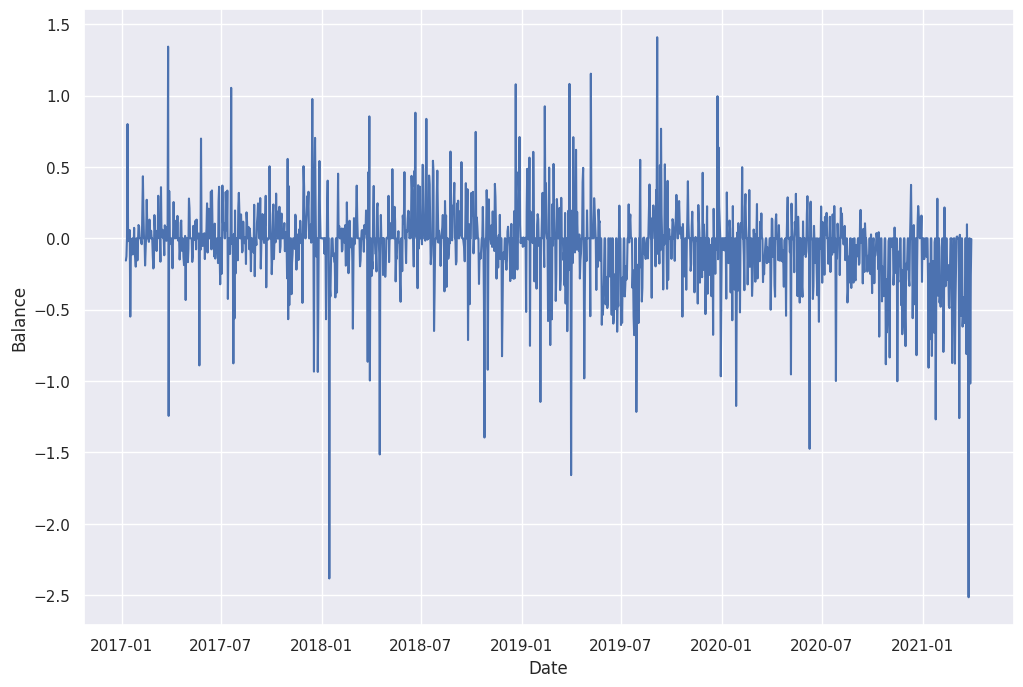

In [77]:
sns.lineplot(data=data, x="Date", y="Balance")

In [82]:
data[['year', 'Income','Outcome','Balance']].groupby('year').agg(['count', 'sum', 'min', 'max', 'mean'])[['Income','Outcome','Balance']]

Income                                      Outcome                   \
      count         sum  min       max      mean   count         sum  min   
year                                                                        
2017    357  318.374477  0.0  3.265402  0.891805     357  311.486408  0.0   
2018    365  387.249254  0.0  3.871082  1.060957     365  387.864240  0.0   
2019    365  425.099709  0.0  3.094232  1.164657     365  444.323962  0.0   
2020    366  427.430026  0.0  5.108775  1.167842     366  463.675423  0.0   
2021     90  115.861343  0.0  3.265402  1.287348      90  142.005859  0.0   

                         Balance                                           
           max      mean   count        sum       min       max      mean  
year                                                                       
2017  3.765746  0.872511     357   6.873045 -1.244018  1.343028  0.019252  
2018  3.752579  1.062642     365  -0.615553 -2.383217  1.079276 -0.001686  
2019  3.660411  1.217326     365 -19.119104 -1.659035  1.408863 -0.052381  
2020  5.003439  1.266873     366 -36.359468 -1.474698  0.498466 -0.099343  
2021  4.687433  1.577843      90 -26.170455 -2.514887  0.277592 -0.290783

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


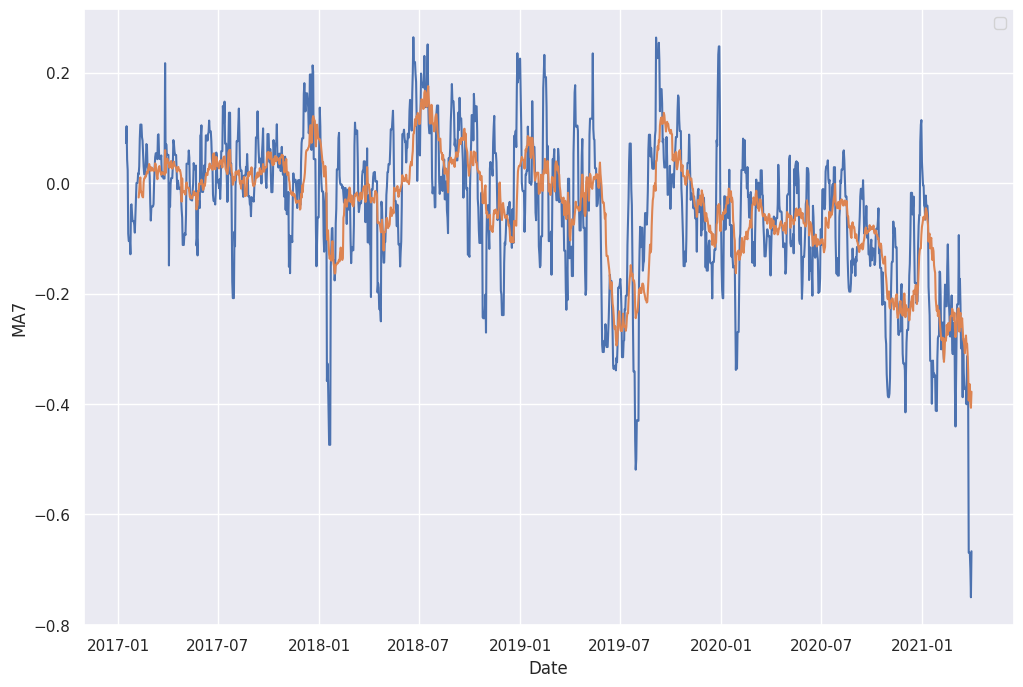

In [88]:
sns.lineplot(data=data, x="Date", y="MA7")
sns.lineplot(data=data, x="Date", y="MA30")
plt.legend()